## Exploratory Data Analysis

With reference to 'WB Data Cleanup.py'; this space will be used to highlight the reasons for the steps chosen to clean the World Bank extracted data. __Check how to hide input cells such that it remains hidden when uploading to github__ Some important characteristics of the dataset:

1. The World Bank's (WB) Indicators data repository contains measurements of thousands of macroeconomic/social indicators over a period of several years. These indicators have been categorized in two ways; topics (based on a common theme for all those measurements, for instance: Energy & Mining) & sources (based on which division of research at the WB provided the data, for instance: World Development Indicators).
2. A large proportion of WB data is collected thru field based activities such as surveys etc. Therefore, missing values due to unreported or incorrectly reported/recorded data can be on the higher side.
3. Several indicators measure the same thing in different units or perspectives. Thus, it is likely that multicollinearity would be significant.
4. The data extracted is country wise, i.e each indicator's value for each country over the period 1960-2012.

### Libs

In [ ]:
import json
import pandas as pd
import numpy as np
from functools import reduce
from xgboost import XGBRegressor
from xgboost import plot_importance
import wbpy
import wbdata
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from plotnine import *
from pdpbox import pdp, info_plots
import seaborn as sns
import warnings
import missingno as msno
warnings.filterwarnings('ignore')

In [5]:
Train=pd.read_pickle(r'C:\Users\AMS\Documents\Machine Learning\World Bank\Df Pickles\temptrash\Train')

In [6]:
Train.shape

(12744, 1650)

In [6]:
Train.head()

Urban population (% of total)  Urban population  \
country date                                                    
Aruba   2018                            NaN               NaN   
        2017                         43.293           45572.0   
        2016                         43.192           45275.0   
        2015                         43.108           44979.0   
        2014                         43.041           44674.0   

              Urban population growth (annual %)  \
country date                                       
Aruba   2018                                 NaN   
        2017                            0.653849   
        2016                            0.655929   
        2015                            0.680404   
        2014                            0.705351   

              Rural population (% of total population)  \
country date                                             
Aruba   2018                                       NaN   
        2017                                    56.707   
        2016                                    56.808   
        2015                                    56.892   
        2014                                    56.959   

              Rural population growth (annual %)  Rural population  \
country date                                                         
Aruba   2018                                 NaN               NaN   
        2017                            0.243209           59692.0   
        2016                            0.311163           59547.0   
        2015                            0.406810           59362.0   
        2014                            0.498526           59121.0   

              Population, male (% of total)  Population, male  \
country date                                                    
Aruba   2018                            NaN               NaN   
        2017                      47.482329           49982.0   
        2016                      47.508515           49799.0   
        2015                      47.534479           49598.0   
        2014                      47.572208           49378.0   

              Population, female (% of total)  Population, female  ...  \
country date                                                       ...   
Aruba   2018                              NaN                 NaN  ...   
        2017                        52.517671             55282.0  ...   
        2016                        52.491485             55023.0  ...   
        2015                        52.465521             54743.0  ...   
        2014                        52.427792             54417.0  ...   

              HOI: Mathematics Proficiency Level 2  \
country date                                         
Aruba   2018                                   NaN   
        2017                                   NaN   
        2016                                   NaN   
        2015                                   NaN   
        2014                                   NaN   

              HOI: Mathematics Proficiency Level 2, Private schools  \
country date                                                          
Aruba   2018                                                NaN       
        2017                                                NaN       
        2016                                                NaN       
        2015                                                NaN       
        2014                                                NaN       

              HOI: Mathematics Proficiency Level 2, Public schools  \
country date                                                         
Aruba   2018                                                NaN      
        2017                                                NaN      
        2016                                                NaN      
        2015                                                NaN      
        2014           

In [5]:
print(Train.isnull().sum().head())
print(Train.isnull().sum().tail())

Urban population (% of total)               398
Urban population                            439
Urban population growth (annual %)          443
Rural population (% of total population)    398
Rural population growth (annual %)          872
dtype: int64
HOI: Mathematics Proficiency Level 3, Public schools    12724
HOI: Reading Proficiency Level 2                        12724
HOI: Reading Proficiency Level 2, Private schools       12724
HOI: Reading Proficiency Level 2, Public schools        12724
HOI: Reading Proficiency Level 3                        12724
dtype: int64


__Clearly, missing values are a major issue. Some columns are completely empty.__

In [7]:
print('Avg missing values per feature:',np.int(Train.isnull().sum().mean()))
print('Percentage:',np.int((Train.isnull().sum().mean()/len(Train)*100)))

Avg missing values per feature: 8565
Percentage: 67


__Given the average missing values above, seems reasonable to remove features (columns) with 80% or more missing values__

In [8]:
MV=Train.isnull().sum()
droplist=[i for i,j in MV.items() if (j/len(Train))>=0.8]
Train.drop(labels=droplist,axis=1,inplace=True)
Train.shape

(12744, 1031)

__Given the column names, its clear that several indicators are measuring closely related metrics, its imperative to check for multicollinearity:__

In [9]:
corr_matrix = Train.corr().abs()
uppertrian = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in uppertrian.columns if any(uppertrian[column] > 0.90)]

In [10]:
print('Number of features with correlation above 90% :',len(to_drop))
to_drop[0:20]

Number of features with correlation above 90% : 477


['Rural population (% of total population)',
 'Population, male',
 'Population, female (% of total)',
 'Population, female',
 'Population, total',
 'Age dependency ratio (% of working-age population)',
 'Land under cereal production (hectares)',
 'Land area (sq. km)',
 'Cereal production (metric tons)',
 'Livestock production index (2004-2006 = 100)',
 'Surface area (sq. km)',
 'Goods imports (BoP, current US$)',
 'Service imports (BoP, current US$)',
 'Imports of goods, services and primary income (BoP, current US$)',
 'Net financial account (BoP, current US$)',
 'Net trade in goods and services (BoP, current US$)',
 'Net trade in goods (BoP, current US$)',
 'Primary income receipts (BoP, current US$)',
 'Exports of goods and services (BoP, current US$)',
 'Goods exports (BoP, current US$)']

__As expected, a high number (477) of features are redundant due to multicollinearity and will be dropped. The reason can be seen from a snapshot of the list of features shown above; the stats being measured deal with similar topics often measuring the same or similar indicator.__

In [11]:
Train.drop(labels=to_drop,axis=1,inplace=True)

__Before any further cleanup operations (specially before starting cleanup on the row axis), it is important to join the Target feature (Temperature) with the main Df.__

### #StartTempCells

In [16]:
s=wbdata.get_country(display=False)
a = {c.get('id'):c.get('iso2Code') for c in s}
b = [key for key, val in a.items() if not val[1].isdigit() if not val[0].isdigit()]
countrylist = [c for c in b if c not in ('UMC','OED','MNA','LMY','LMC','LIC','LDC','EMU','NAC','SSA',\
                         'LAC','LCN','INX','IDX','IDB','IDA','IBT','IBD','IBB','HPC','HIC','EUU','SSF',\
                                          'MIC','MEA','CHI')]

In [29]:
# c_api = wbpy.ClimateAPI()
# dataset1 = c_api.get_instrumental(data_type="tas", interval="year", locations=countrylist)
# dataset1=dataset1.as_dict()
# ClimateDf=pd.DataFrame(dataset1).unstack().reset_index()
# CountryNames={}
# for c in s:
#     a=c.get('id')
#     for f in countrylist:
#         if a==f:
#             CountryNames[a]=c.get('name')
# ClimateDf['level_0']=ClimateDf['level_0'].map(CountryNames)
# ClimateDf=ClimateDf.rename(mapper={'level_0':'country', 'level_1':'date',0:'Temp(C)'},axis=1)

### #EndTempCells

In [49]:
Train=pd.merge(Train,ClimateDf,on=['country','date'])
emptytarget=Train[Train['Temp(C)'].isnull()].index
Train.drop(index=emptytarget,inplace=True)
Train.reset_index(inplace=True)
Train.drop(labels='index',axis=1,inplace=True)

__All rows that had no temperature value have been removed, no point in training examples with no target value. The code for extraction of the 'countrylist' and the 'ClimateDf' is not shown here. Its available in 'WBScraper.py'. Important observations:__
- The date range of the Df is now 1960-2012; this is basically the intersecting date range of the indicators data and climate data.
- Training examples have been reduced to 11,052.

__Lets get a snapshot of the missing values__

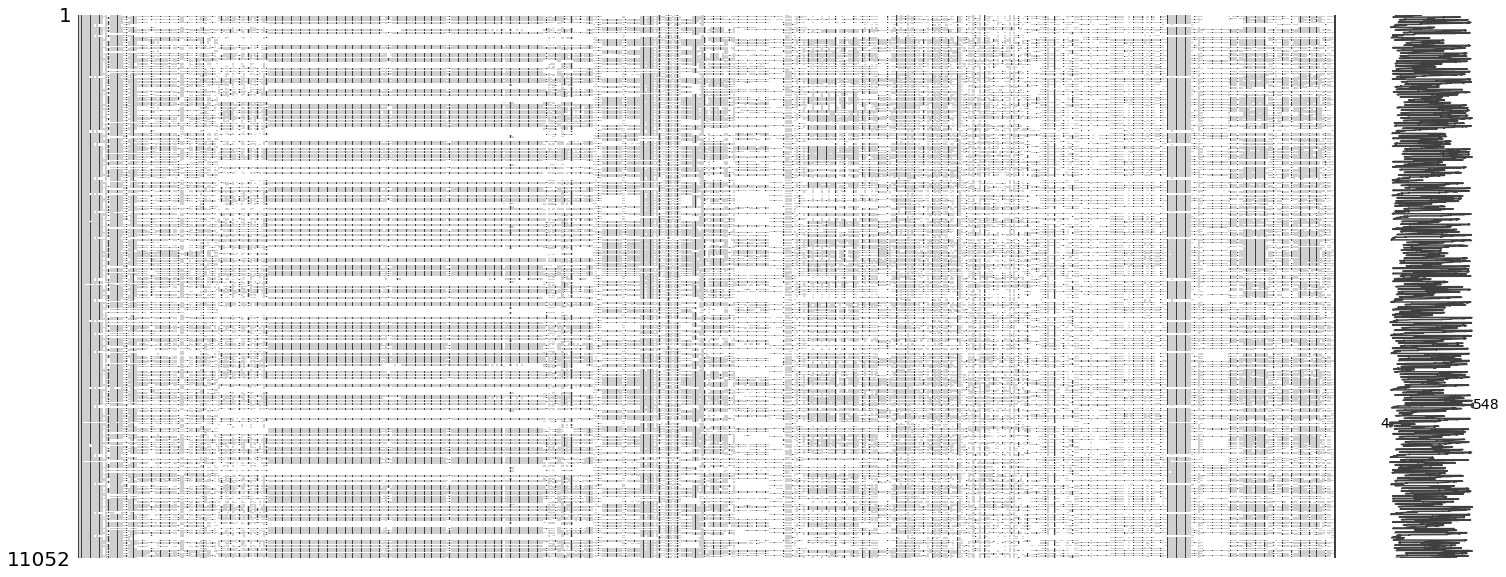

In [50]:
msno.matrix(Train)

__Observations based on the missing values plot above:__
- Revisiting the fact that the data is countrywise at first level and datewise at the next, it can be seen that some countries would have a very high proportion of missing values
- The distribution of missing values is fairly random with only a handful of features having a high proportion of available data

__Since each country is a 'Df of sorts' on its own, it is plausible to remove countries with 90% or higher missing values:__

In [51]:
indices=[Train[Train['country']==i].index for i,j in Train.groupby('country') if (j.isnull().sum().mean()/len(j))>=0.9]
droplist=[a for i in indices for a in i]
Train.drop(index=droplist,inplace=True)
Train.reset_index(inplace=True)
Train.drop(labels='index',axis=1,inplace=True)

__11 countries have been removed, training examples (Rows) have been reduced to 10499.__

__Given the fact that we are trying to analyze the effect of macroeconomic indicators on temperature change, there are a few modifications that will have to be made to the features as follows:__
- The primary issue with countrywise data is the impact of geography. Geographic location impacts several aspects of a country's macroeconomic activities and is probably the sole most important determinant of temperature. Therefore:
    - The target feature (Temp(C)) will be converted to an index with base year 1960. This will help countrywise standardisation and help control for geographic location. This will also help capture the change in temperature better. Also, this is a very common method of recording and analyzing temperature data on climate data repositories.
    - The rest of the features will be standardised countrywise by using each country's mean and individually subtracting it from that country's values. The reasons to not convert all the other features to indexes is: since there is a high number of missing values, indexing has the effect of increasing them even more (number-NaN=NaN and vice versa). 

__Countrywise Standardisation of independent features (country, date and Temp(C) will not be standardised), this was accomplished using the Column Transformer function:__

In [ ]:
CountryWiseDf={s:d for s,d in Train.groupby('country')}
cols=Train.columns.tolist()
cols=cols[+2:-1]+cols[:+2]+cols[-1:]
StandardisedDfs={}
for s,d in CountryWiseDf.items():
    ctr=ColumnTransformer([('strange',StandardScaler(),[i for i in d.columns if i not in ['country','date','Temp(C)']])],verbose=True,remainder='passthrough')
    strain=ctr.fit_transform(d)
    strain=pd.DataFrame(strain,columns=cols)
    StandardisedDfs[s]=strain

__Conversion of target feature (Temp(C)) to index with base year 1960:__

In [55]:
for i,g in StandardisedDfs.items():
    base=float(g[g['date']=='1960']['Temp(C)'])
    g['Temp(C)']=g['Temp(C)']-base
newdfs=[j for i,j in StandardisedDfs.items()]
Train=pd.concat(newdfs)
Train=Train.infer_objects()

__Following cell creates a cross validation/Test set called 'Val'. The validation set has not been selected randomly due to the temporal nature of the data. The latest available year (2012) has been selected for the purpose. This constitutes around 2% of the dataset.__

In [ ]:
Train.country=Train.country.astype('category').cat.codes
Train.date=Train.date.astype('int16')
Val=Train[Train['date']==2012]
Train.drop(index=Val.index,inplace=True)
Train.reset_index(inplace=True)
Val.reset_index(inplace=True)
Train.drop(labels='index',axis=1,inplace=True)
Val.drop(labels='index',axis=1,inplace=True)

In [ ]:
Xtrain= Train.loc[:,Train.columns!='Temp(C)']; ytrain= Train.loc[:,'Temp(C)']
Xval= Val.loc[:,Train.columns!='Temp(C)']; yval= Val.loc[:,'Temp(C)']

Xtrain.drop(labels='date',axis=1,inplace=True)
Xval.drop(labels='date',axis=1,inplace=True)

In [ ]:
xgb=XGBRegressor(objective='reg:squarederror',n_jobs=-1,n_estimators=5000,subsample=0.55,colsample_bytree=0.65,\
                colsample_bylevel=0.75,learning_rate=0.06, verbosity=0)
xgb.fit(Xtrain,ytrain, eval_set=[(Xtrain,ytrain),(Xval,yval)],eval_metric='rmse', early_stopping_rounds=70)

In [125]:
xgb=XGBRegressor(objective='reg:squarederror',n_jobs=-1,n_estimators=5000,subsample=0.55,colsample_bytree=0.65,\
                colsample_bylevel=0.75,learning_rate=0.06, verbosity=0)
xgb.fit(Xtrain,ytrain, eval_set=[(Xtrain,ytrain),(Xval,yval)],eval_metric='rmse', early_stopping_rounds=70)

print('Initial RMSE on Validation set:', '0.59137')
print('Score on best iteration:',xgb.best_score)
print('Percentage improvement:',np.round((1-xgb.best_score/0.59137)*100,0))

Initial RMSE on Validation set: 0.59137
Score on best iteration: 0.442969
Percentage improvement: 25.0
